In [3]:
# from PIL import Image
# import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib.colors import ListedColormap

## Turn the .tiff file image data into handeble .h5 data file. 

In [13]:
# # Import .tif file
# im = Image.open("/home/rutian/Videos/cut1.tif")

# tif_path = "/home/rutian/Videos/cut1.tif"

# with tiff.TiffFile(tif_path) as tif:
#     image_stack = tif.asarray()

# # The data from two channels. Use type uint8 to sparse space. 
# channel_green = image_stack[:, 0, :, :] # The green channel with aggregates.
# all_green_frames = np.array(channel_green)

# channel_red = image_stack[:, 1, :, :] # The channel with red beads.
# all_red_frames = np.array(channel_red)

# # Store the image information into .h5 file. With compression algorithm "gzip" and compression factor 5 (max 9). 
# h5_file_path = "cut1.h5"
# with h5py.File(h5_file_path, "w") as h5f:
#     h5f.create_dataset("green", data = all_green_frames, compression="gzip", compression_opts=5)
#     h5f.create_dataset("red", data = all_red_frames, compression="gzip", compression_opts=5)

## Import .h5 data containing aggregate and red beads channels.

In [4]:
# open h5 files.

h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1(2).h5"
with h5py.File(h5_file_path, "r") as h5f:
    green_channel = h5f["green"][:]
    red_channel = h5f["red"][:]

In [5]:
print("green channel shape:", green_channel.shape)
print("red beads shape:", red_channel.shape)

green channel shape: (375, 900, 800)
red beads shape: (375, 900, 800)


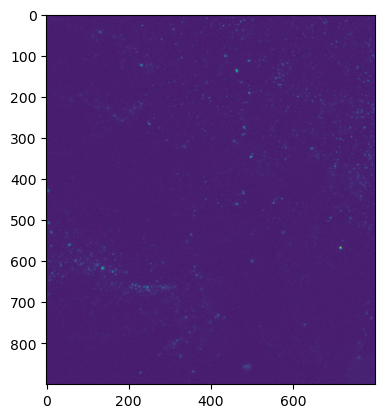

In [6]:
plt.imshow(red_channel[200])

## Apply masks to find the region covered by skin and cut out the region for red beads.
## At the same time, also segment red beads.

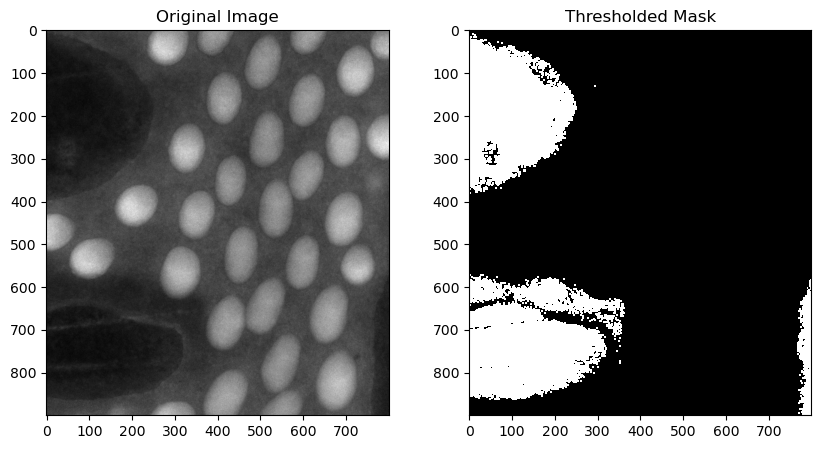

In [46]:
image = green_channel[300]
#threshold = np.median(image)
#threshold_value = 10  # Adjust this value as needed
#mask = np.where(image > threshold_value, 0, 1) # Above to 0 and below to 1.
mask = np.where(image > 140, 0, np.nan)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Thresholded Mask")
plt.imshow(mask, cmap='gray')
plt.show()

In [12]:
def overlap_mask(green_channel, red_channel, t):
    # Red channel with red beads. Green channel of cut skin. 
    # The mask from green channel define the covered regions. 
    # The mask from red channel is for piv analysis on beads.
    # Overlap the masks to ensure that the piv analysis of red beads is only on the region covered by skin. 
    green_image = green_channel[t]
    red_image = red_channel[t]

    green_threshold = 140 
    red_threshold = np.median(red_image)

    green_mask = np.where(green_image > green_threshold, 0, np.nan) # Above threshold 0, under threshold (background) nan. 
    red_mask = np.where(red_image > red_threshold, 1, 0)

    return (green_mask + red_mask)

In [97]:
def all_frame_overlap_mask(green_channel, red_channel):
    # Generate overlap masks for all frames. 
    total_frame = green_channel.shape[0]
    masks = []
    for t in range(total_frame): 
        masks.append(overlap_mask(green_channel, red_channel, t))
    return np.array(masks)

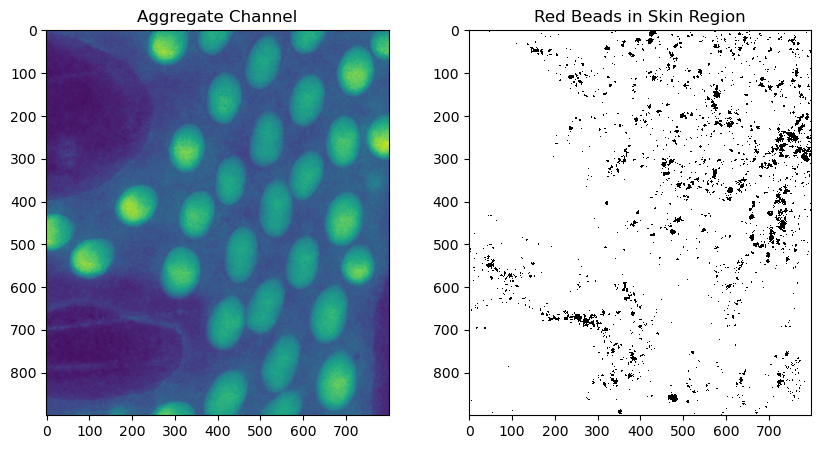

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Aggregate Channel")
plt.imshow(green_channel[300])
plt.subplot(1, 2, 2)
plt.title("Red Beads in Skin Region")
plt.imshow(overlap_mask(green_channel, red_channel, 300), cmap= ListedColormap(["white", "black"]))
plt.show()

## Store the masked red beads for all frames

In [111]:
all_mask = all_frame_overlap_mask(green_channel, red_channel)

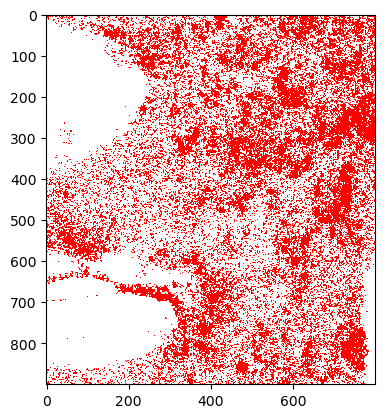

In [112]:
plt.imshow(all_mask[300], cmap= ListedColormap(["white", "red"]))

In [113]:
all_mask[300]

array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  1.,  1., ...,  0.,  1.,  1.],
       [ 0.,  1.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  1.,  1., ..., nan,  0., nan],
       [ 1.,  0.,  1., ...,  0., nan, nan],
       [ 1.,  0.,  0., ...,  0., nan, nan]])

In [88]:
h5_file_path = "mask_red_beads_cut1.h5"
with h5py.File(h5_file_path, "w") as h5f:
    h5f.create_dataset("masked_red_beads", data = all_mask)